In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/SOP_COVID/covid-audio/voice

/content/gdrive/My Drive/SOP_COVID/covid-audio/voice


In [3]:
numpy.random.seed(42)

NameError: ignored

In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import itertools
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
import seaborn as sns
import pickle

audioType = 'breath'
data_path = f'data_struc/data_{audioType}'

train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
val = pd.read_csv(os.path.join(data_path, 'valid.csv'))

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
val = val.loc[:, ~val.columns.str.contains('^Unnamed')]

train['target'] = train['target'].apply(lambda x: 0 if x == 'covid' else 1)
test['target'] = test['target'].apply(lambda x: 0 if x == 'covid' else 1)
val['target'] = val['target'].apply(lambda x: 0 if x == 'covid' else 1)

train.dropna(inplace=True)
test.dropna(inplace=True)
val.dropna(inplace=True)

dataset = pd.concat([train, test, val], ignore_index=True)

covid_samples = dataset[dataset['target'] == 0]
normal_samples = dataset[dataset['target'] == 1]

train_covid, test_covid = train_test_split(covid_samples, test_size=0.2)
train_normal, test_normal = train_test_split(normal_samples, test_size=0.2)

train = pd.concat([train_covid, train_normal], ignore_index=True)
test = pd.concat([test_covid, test_normal], ignore_index=True)

train = shuffle(train, random_state=2)
test = shuffle(test, random_state=2)

In [5]:
covid, normal = 0, 0
for idx, row in train.iterrows():
    if(row['target'] == 0):
        covid += 1
    else:
        normal += 1

print(covid)
print(normal)

137
634


In [6]:
covid, normal = 0, 0
for idx, row in test.iterrows():
    if(row['target'] == 0):
        covid += 1
    else:
        normal += 1

print(covid)
print(normal)

35
159


In [7]:
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_val = val.drop('target', axis=1)
y_val = val['target']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Applying PCA

In [8]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
explained_variance = [i*100 for i in explained_variance]

In [9]:
explained_variance

[20.922640412761716,
 12.378655695869885,
 9.58224309089077,
 6.217667290237117,
 4.550362034753989,
 4.11278480599927,
 3.944658829071295,
 3.339505298189195,
 3.1270563733550585,
 2.8334531697816794,
 2.6986895752066458,
 2.353297415160442,
 2.005389070435599,
 1.8320980085654808,
 1.4409550526541153,
 1.3719779850850256,
 1.2430977861714112,
 1.0300624217253065,
 0.9691830410898131,
 0.8672658233651724,
 0.6959625149536953,
 0.6606835884593697,
 0.6155602277918181,
 0.5765794598075641,
 0.560210603057345,
 0.530182165973557,
 0.4709894355543958,
 0.4474899025406123,
 0.41247857711149244,
 0.4057222567999685,
 0.3804709843057698,
 0.3658110718937528,
 0.34451213974466277,
 0.3311316375857304,
 0.30661680148237536,
 0.2998510985259153,
 0.27918590346121347,
 0.26558264769058815,
 0.2546942765416137,
 0.24308471199647827,
 0.23151889760962713,
 0.22407735872059412,
 0.21566118889292102,
 0.20516759803588733,
 0.18946009779849277,
 0.17879304011070127,
 0.17691646906501687,
 0.175292907

In [10]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

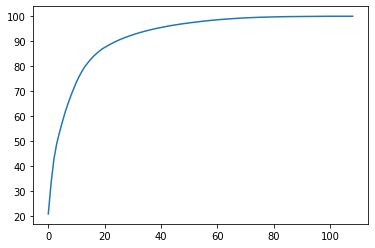

In [11]:
plt.plot(cumulative_variance)

In [12]:
pca = PCA(n_components=20)
# pca = PCA(0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [13]:
with open('pca_weights_breath.pkl', 'wb') as f:
    pickle.dump(pca, f)

## Training and Making Predictions


[[  0  35]
 [  0 159]]
Accuracy:  0.8195876288659794
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.82      1.00      0.90       159

    accuracy                           0.82       194
   macro avg       0.41      0.50      0.45       194
weighted avg       0.67      0.82      0.74       194



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


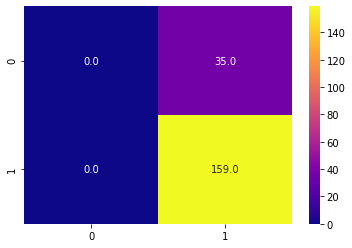

In [14]:
### Random Forest Classifier

rfclassifier = RandomForestClassifier(max_depth=2, random_state=0)
rfclassifier.fit(X_train, y_train)

y_pred = rfclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[  8  27]
 [  9 150]]
Accuracy:  0.8144329896907216
              precision    recall  f1-score   support

           0       0.47      0.23      0.31        35
           1       0.85      0.94      0.89       159

    accuracy                           0.81       194
   macro avg       0.66      0.59      0.60       194
weighted avg       0.78      0.81      0.79       194



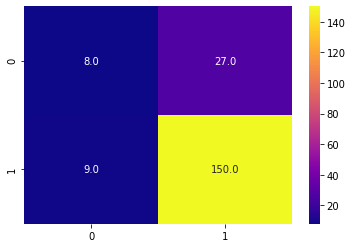

In [15]:
### Logistic Regression

logreg_clf = LogisticRegression(multi_class='ovr')
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[  9  26]
 [  1 158]]
Accuracy:  0.8608247422680413
              precision    recall  f1-score   support

           0       0.90      0.26      0.40        35
           1       0.86      0.99      0.92       159

    accuracy                           0.86       194
   macro avg       0.88      0.63      0.66       194
weighted avg       0.87      0.86      0.83       194



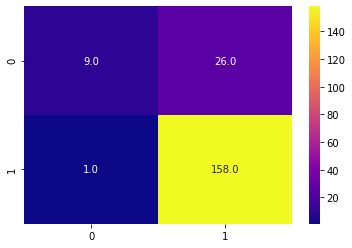

In [16]:
### SVM

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [17]:
classifier = SVC(probability=True)

In [18]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
} 

grid = GridSearchCV(classifier, param_grid, refit = True, cv=10, n_jobs=-1)

grid.fit(X_train, y_train) 

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


[[ 29   6]
 [  2 157]]
Accuracy:  0.9587628865979382
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        35
           1       0.96      0.99      0.98       159

    accuracy                           0.96       194
   macro avg       0.95      0.91      0.93       194
weighted avg       0.96      0.96      0.96       194



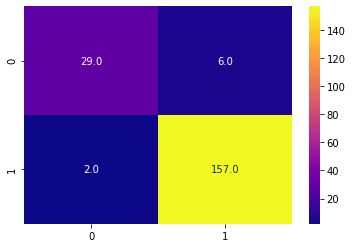

In [20]:
y_pred = grid.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [21]:
model_name = 'model_ML_breath.pkl'

In [22]:
model_name = 'model_ML_breath.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(grid, f)

## Test File

In [ ]:
model_name = 'model_ML_cough.pkl'

In [ ]:
with open(model_name, 'rb') as f:
    classifier = pickle.load(f)

with open('pca_weights.pkl', 'rb') as f:
    pca = pickle.load(f)

In [ ]:
# Audio parameters that will be used across all the techniques. Note that you
# will have to run make all in this directory before the changes take effect
# across the board.

# Set to True to ignore class asthma for data_rnn, data_spec and data_struc.
# Note that however, for data_raw, data_clean and eda, class asthma samples
# will still be used.
ignore_asthma = True

# Common parameters across ALL models
sampling_rate = 16000
samples_per_frame = 256
hop_length = samples_per_frame // 4
# Looping/clipping breath audio samples to the same length time_per_sample (in
# seconds). Refer eda/eda_audio_len.ipynb for stats on audio sample times.
time_per_sample_breath = 24.29  # 95th percentile value for breath.
time_per_sample_cough = 9.92    # 95th percentile value for cough.

# Parameters for SPECTROGRAM models (CNNs) -- data_spec directory
n_mels = 64

# Parameters for TRADITIONAL ML models -- data_struc directory
struc_global_features = []            # Global features need not be aggregated for an audio sample.
struc_instantaneous_features = ['rmse',
                                'zcr',
                                'sc',
                                'sb',
                                'sr',
                                'mfcc']   # Instantaneous features need to be aggregated for an audio sample.
struc_agg_funcs = [             'mean',
                                'median',
                                'rms',
                                'max',
                                'min',
                                # 'q1',
                                # 'q3',
                                # '10',
                                # '90',
                                # 'iqr',
                                # 'std',
                                # 'skew',
                                # 'kurtosis',
                                'rewm']    # Aggregation functions to use. Refer to data_struc/feature_extraction_utils.py for allowed aggregate functions.
struc_roll_percent = 0.85       # Percentage for spectral rolloff.
struc_n_mfcc = 13               # Number of MFCC coefficients to consider.

# Parameters for RECURRENT models -- data_rnn directory
rnn_instantaneous_features = ['rmse', 'zcr', 'sc', 'sb', 'sr', 'mfcc']   # Using only instantaneous features, without aggregation to preserve time component for RNN. Global features not used.
rnn_roll_percent = 0.85         # Percentage for spectral rolloff.
rnn_n_mfcc = 13                 # Number of MFCC coefficients to consider.

In [ ]:
def load(audio_path, sampling_rate, time_per_sample):
    """
    Wrapper around librosa.load. If the audio sample is shorter than
    time_per_sample (you can set this in set_audio_params.py), it is looped back
    to time_per_sample seconds. Else if it is shorter than time_per_sample, it
    is clipped to time_per_sample seconds. Use this in place of librosa.load
    throughout this project.
    Parameters:
    audio_path (str): Absolute/relative path to audio file.
    sampling_rate (float): Number of samples to take per second (discretizing
        time).
    time_per_sample (float): Read description above for explanation.
    Returns:
    tuple: Tuple containing waveform (NumPy array), sampling_rate (float).
    """

    # Standard sampling rate is 44100 Hz.
    waveform, sampling_rate = librosa.load(audio_path, sr=sampling_rate)

    # Looping back if longer, clipping if shorter.
    waveform = np.resize(waveform, int(time_per_sample * sampling_rate))

    return waveform, sampling_rate

In [ ]:
# Aggregate functions taken in the KDD paper.
agg_funcs_allowed = [
    'mean',     # Arithmetic mean
    'median',   # Median
    'rms',      # Root mean square value
    'max',      # Maximum
    'min',      # Minimum
    'q1',       # 1st quartile
    'q3',       # 3rd quartile
    'iqr',      # Interquartile range
    'std',      # Standard deviation
    'skew',     # Skewness
    'kurtosis', # Kurtosis
    'rewm'      # A custom aggregation function rms energy weighted mean, not
                # given in the KDD paper.
    # Integer values in the range [0, 100] are also allowed, representing the
    # percentile value in arr. For example, passing 95 would return the 95th
    # percentile value in arr. This too is not used in the KDD paper.
]

# Function to aggregate frame-level/instantaneous features to 1 value for the
# whole audio sample.
def aggregate(arr, agg_func, rms=None):
    if not (agg_func in agg_funcs_allowed or (agg_func.isnumeric() and (0 <= float(agg_func) <= 100))):
        raise ValueError(f'agg_func must be one among {agg_funcs_allowed} or a float in the range [0, 100] represented as a string.')
    if arr.ndim != 1 and arr.ndim != 2:
        raise ValueError(f'arr must be a tensor of rank 1.')

    if agg_func == 'mean':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.mean(arr, axis=1)
        return np.mean(arr)
    elif agg_func == 'median':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.median(arr, axis=1)
        return np.median(arr)
    elif agg_func == 'rms':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.sqrt(np.sum(arr ** 2, axis=1) / arr.shape[1])
        return np.sqrt(np.sum(arr ** 2) / len(arr))
    elif agg_func == 'max':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.max(arr, axis=1)
        return np.max(arr)
    elif agg_func == 'min':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.min(arr, axis=1)
        return np.min(arr)
    elif agg_func == 'q1':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.percentile(arr, 25, axis=1)
        return np.percentile(arr, 25)
    elif agg_func == 'q3':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.percentile(arr, 75, axis=1)
        return np.percentile(arr, 75)
    elif agg_func == 'iqr':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.percentile(arr, 75, axis=1) - np.percentile(arr, 25, axis=1)
        return np.percentile(arr, 75) - np.percentile(arr, 25)
    elif agg_func == 'std':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.std(arr, axis=1)
        return np.std(arr)
    elif agg_func == 'skew':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return scipy.stats.skew(arr, axis=1)
        return scipy.stats.skew(arr)
    elif agg_func == 'kurtosis':
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return scipy.stats.kurtosis(arr, axis=1)
        return scipy.stats.kurtosis(arr)
    elif agg_func == 'rewm':
        # Using this option requires RMS energy vector.
        if rms is None:
            raise ValueError('aggregate with agg_func as rms_energy_weighted_mean requires rms parameter.')
        # Handles case of MFCC matrix as well, which has shape (struc_n_mfcc, num_frames).
        return np.dot(arr, rms) / np.sum(rms)
    elif agg_func.isnumeric() and 0 <= float(agg_func) <= 100:
        # For MFCCs, calculating across time, axis=1.
        if arr.ndim == 2:
            return np.percentile(arr, float(agg_func), axis=1)
        return np.percentile(arr, float(agg_func))

# INSTANTANEOUS FEATURES
# Wrappers around librosa functions that:
# 1. Use more intuitive names.
# 2. Convert optional arguments to compulsory arguments. I've spent too much
#    time debugging before just to realize later that I hadn't provided an
#    optional argument that was required to generate a desired result.
# 3. Get rid of distracting options not required by this project.
def rms_energy(waveform, samples_per_frame, hop_length):
    return librosa.feature.rms(y=waveform, frame_length=samples_per_frame, hop_length=hop_length).flatten()

def zero_crossing_rate(waveform, samples_per_frame, hop_length):
    return librosa.feature.zero_crossing_rate(waveform, frame_length=samples_per_frame, hop_length=hop_length).flatten()

def spectral_centroid(waveform, sampling_rate, samples_per_frame, hop_length):
    return librosa.feature.spectral_centroid(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length).flatten()

def spectral_bandwidth(waveform, sampling_rate, samples_per_frame, hop_length):
    return librosa.feature.spectral_bandwidth(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length).flatten()

def spectral_rolloff(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent):
    return librosa.feature.spectral_rolloff(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length, roll_percent=roll_percent).flatten()

def mfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc):
    return librosa.feature.mfcc(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length, n_mfcc=n_mfcc)

def dmfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc):
    mfcc = librosa.feature.mfcc(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length, n_mfcc=n_mfcc)
    return librosa.feature.delta(mfcc)

def d2mfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc):
    mfcc = librosa.feature.mfcc(waveform, sr=sampling_rate, n_fft=samples_per_frame, hop_length=hop_length, n_mfcc=n_mfcc)
    return librosa.feature.delta(mfcc, order=2)

# AGGREGATE INSTANTANEOUS FEATURES
# Note that aggregate function 'rewm' requires slightly different treatment (it
# requires the root mean square energies rms to be passed to the aggregate
# function), because of the definition of 'rewm'.
def rms_energy_agg(waveform, samples_per_frame, hop_length, agg_func='95', rms=None):
    """ Returns aggregate of framewise RMS energies, for an audio clip. """
    rms_energies = rms_energy(waveform, samples_per_frame, hop_length)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate rms energy.
        # I don't know if it makes sense to weight rms energy with rms energy
        # to aggregate it, it'd just be squaring the rms energies over the
        # frames, and taking their mean. Keeping it for the sake of consistency.
        # If required, it can be removed from the csv files.
        return aggregate(rms_energies, agg_func, rms=rms)
    return aggregate(rms_energies, agg_func)

def zero_crossing_rate_agg(waveform, samples_per_frame, hop_length, agg_func, rms=None):
    """ Returns aggregate of framewise zero crossing rates, for an audio clip. """

    zcr = zero_crossing_rate(waveform, samples_per_frame, hop_length)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(zcr, agg_func, rms=rms)
    return aggregate(zcr, agg_func)

def spectral_centroid_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func, rms=None):
    """ Returns aggregate of spectral centroids, for an audio clip. """

    spec_centroids = spectral_centroid(waveform, sampling_rate, samples_per_frame, hop_length)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(spec_centroids, agg_func, rms=rms)
    return aggregate(spec_centroids, agg_func)

def spectral_bandwidth_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func, rms=None):
    """ Returns aggregate of framewise spectral bandwidths, for an audio clip. """

    spec_bws = spectral_bandwidth(waveform, sampling_rate, samples_per_frame, hop_length)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(spec_bws, agg_func, rms=rms)
    return aggregate(spec_bws, agg_func)

def spectral_rolloff_agg(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent, agg_func, rms=None):
    """ Returns aggregate of framewise spectral rolloffs, for an audio clip. """

    spec_rolloffs = spectral_rolloff(waveform, sampling_rate, samples_per_frame, hop_length, roll_percent)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(spec_rolloffs, agg_func, rms=rms)
    return aggregate(spec_rolloffs, agg_func)

def mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func, rms=None):
    """ Returns aggregate across time axis (axis=1) of MFCCs, for an audio clip. """

    mfccs = mfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(mfccs, agg_func, rms=rms)
    return aggregate(mfccs, agg_func)

def dmfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func, rms=None):
    """ Returns aggregate across time axis (axis=1) of derivative of MFCCs, for an audio clip. """

    dmfccs = dmfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(dmfccs, agg_func, rms=rms)
    return aggregate(dmfccs, agg_func)

def d2mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc, agg_func, rms=None):
    """ Returns aggregate across time axis (axis=1) of second derivative of MFCCs, for an audio clip. """

    d2mfccs = d2mfcc(waveform, sampling_rate, samples_per_frame, hop_length, n_mfcc)
    if agg_func == 'rewm':
        # Using RMS energy to weight frames. Frames with higher RMS energy
        # contribute more to aggregate zero crossing rate.
        rms = rms_energy(waveform, samples_per_frame, hop_length)
        return aggregate(d2mfccs, agg_func, rms=rms)
    return aggregate(d2mfccs, agg_func)

In [ ]:
def generate_feature_names():
    """
    Generates names of feature columns to be used in the training and test dataframes from the feature names mentioned in set_audio_params.py.
    Parameters:
    None
    Returns:
    list: List of names of feature columns to be used in the training and test dataframes.
    """

    # MFCC features are instantaneous features.
    if 'mfcc' in struc_instantaneous_features:
        mfcc_features = ['mfcc' + str(i) for i in range(1, struc_n_mfcc + 1)]
        struc_instantaneous_features.extend(mfcc_features)

    # Removing the dummy literal 'mfcc' which stood for all coefficients from mfcc0
    # to mfcc<struc_n_mfcc>, as we have already handled the mfcc features above.
    if 'mfcc' in struc_instantaneous_features:
        struc_instantaneous_features.remove('mfcc')

    # Generating feature names for struc_instantaneous_features x struc_agg_funcs.
    struc_instantaneous_features_agg = [instantaneous_feature + '_' + str(agg_func) for instantaneous_feature, agg_func in itertools.product(struc_instantaneous_features, struc_agg_funcs)]

    # print(f'Using {len(struc_instantaneous_features)} instantaneous features (IF):')
    # [print(instantaneous_feature, end='\t') for instantaneous_feature in struc_instantaneous_features]
    # print()

    # print(f'Using {len(struc_agg_funcs)} aggregation functions (AF):')
    # [print(agg_func, end='\t') for agg_func in struc_agg_funcs]
    # print()

    # print(f'Using {len(struc_global_features)} global features (GF):')
    # [print(global_feature, end='\t') for global_feature in struc_global_features]
    # print()

    # print(f'Total number of features = IF * AF + GF = {len(struc_instantaneous_features_agg) + len(struc_global_features)}')
    # print()

    # All features
    features = struc_instantaneous_features_agg + struc_global_features

    return features

def generate_feature_row(orig_df, filename, class_, waveform, sampling_rate, samples_per_frame, hop_length):
    """ Returns a row of features as a Pandas DataFrame. """

    # row_df will be appended to orig_df, hence must have same columns.
    row_df = pd.DataFrame(columns=orig_df.columns)

    # Pre-calculating rms energy if agg_func is rewm. Remember that rewm
    # requires slightly different treatment than the other aggregate functions.
    # Passing it as a parameter regardless of the aggregate functions, if it is
    # not rewm, rms is ignored.
    rms = rms_energy(waveform, samples_per_frame, hop_length)

    for feature in row_df.columns:
        # Instantaneous aggregate features contain '_' as substring.
        if '_' in feature:
            feature_name, agg_func = feature.split('_')

            if feature_name == 'rmse':
                row_df.loc[filename, feature_name + '_' + agg_func] = rms_energy_agg(waveform, samples_per_frame, hop_length, agg_func, rms=rms)
            elif feature_name == 'zcr':
                row_df.loc[filename, feature_name + '_' + agg_func] = zero_crossing_rate_agg(waveform, samples_per_frame, hop_length, agg_func, rms=rms)
            elif feature_name == 'sc':
                row_df.loc[filename, feature_name + '_' + agg_func] = spectral_centroid_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func, rms=rms)
            elif feature_name == 'sb':
                row_df.loc[filename, feature_name + '_' + agg_func] = spectral_bandwidth_agg(waveform, sampling_rate, samples_per_frame, hop_length, agg_func, rms=rms)
            elif feature_name == 'sr':
                row_df.loc[filename, feature_name + '_' + agg_func] = spectral_rolloff_agg(waveform, sampling_rate, samples_per_frame, hop_length, struc_roll_percent, agg_func, rms=rms)
            # Handling MFCC separately.
            elif 'mfcc' in feature_name:
                continue

        elif feature == 'target':
            row_df.loc[filename, feature] = class_

        # Global features.
        else:
            # No global features yet.
            pass

    # Handling MFCC features separately.
    mfcc_features = [feature for feature in orig_df.columns.tolist() if 'mfcc' in feature]
    # Sanity check that max mfcc coefficient in mfcc_features is same as struc_n_mfcc from set_audio_params.py.
    assert struc_n_mfcc == max([int(mfcc_feature.split('_')[0][4:]) for mfcc_feature in mfcc_features])
    mfcc_struc_agg_funcs = set([mfcc_feature.split('_')[1] for mfcc_feature in mfcc_features])

    for agg_func in struc_agg_funcs:
        # Vector of mfcc_max_coef number of MFCCs.
        mfcc_vec = mfcc_agg(waveform, sampling_rate, samples_per_frame, hop_length, struc_n_mfcc, agg_func, rms=rms)
        for i in range(1, struc_n_mfcc + 1):
            row_df.loc[filename, 'mfcc' + str(i) + '_' + str(agg_func)] = mfcc_vec[i - 1]

    return row_df

def add_is_cough_symptom(filename):
    """ Returns whether cough is a symptom, using the filename (index of the dataframe). """

    # Filename convention comes useful here.
    # Filename convention comes useful here.
    is_symptom = filename.split('_')[2]

    if 'with' in is_symptom:
        return 1
    elif 'no' in is_symptom:
        return 0
    else:
        print('Make sure the filename convention is followed.')
        sys.exit(1)

In [ ]:
def extract_features(filepath, audio_type):
    """
    Extracts the same features as used to train the model (refer set_audio_params.py or data_struc/train.csv) from the input audio sample at filepath.
    Wrapper around generate_feature_row from generate_features.py.
    Parameters:
    filepath (str): Path to audio file.
    audio_type (str): Can be 'breath' or 'cough'.
    Returns:
    pandas.DataFrame: Row of features as a Pandas DataFrame.
    """

    features = generate_feature_names()

    # No target column as we need to predict.
    orig_df = pd.DataFrame(columns=features + ['filename'])
    orig_df = orig_df.set_index('filename')

    if audio_type == 'breath':
        waveform, _ = load(filepath, sampling_rate, time_per_sample_breath)
    elif audio_type == 'cough':
        waveform, _ = load(filepath, sampling_rate, time_per_sample_cough)

    # class_ parameter is used only if feature_name is 'target'. However, we don't pass 'target' as the name of a feature column, so passing a dummy value for class_.
    filename = os.path.basename(filepath)
    row_df = generate_feature_row(orig_df, filename, -1, waveform, sampling_rate, samples_per_frame, hop_length)

    return row_df

In [ ]:
def predict(filepath, classifier, audio_type, is_cough_symptom):
    """
    Predicts whether an audio sample is normal or covid.
    Parameters:
    filepath (str): Path to audio file.
    classifier (sklearn.base.BaseEstimator): scikit-learn estimator object with predict method.
    audio_type (str): Can be 'breath' or 'cough'.
    is_cough_symptom (boolean): Corresponds to is_cough_symptom in train.csv, whether the user reported cough as a symptom or not.
    Returns:
    int: Output of predict method of classifier (by default 0 for normal, 1 for covid).
    """

    row_df = extract_features(filepath, audio_type)
    row_df['is_cough_symptom'] = is_cough_symptom

    row_df = pca.transform(row_df)

    # row_df.to_csv('tmp.csv')

    return classifier.predict(row_df)[0]

In [ ]:
for i in range(1, 14):
    filepath = 'Testing/NORMAL' + str(i) + '.wav'
    audio_type = 'cough'
    is_cough_symptom = 1
    print(predict(filepath, classifier, audio_type, is_cough_symptom))

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


In [ ]:
for i in range(1, 14):
    filepath = 'Testing/COVID' + str(i) + '.wav'
    audio_type = 'cough'
    is_cough_symptom = 1
    print(predict(filepath, classifier, audio_type, is_cough_symptom))

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


1
